In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from dataclasses import dataclass, field
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple
# import pyrr

np.set_printoptions(suppress=True)
%matplotlib ipympl

In [2]:
def rot_mat_from_angles(angle):
    pitch, yaw, roll = angle  # R_x, R_y, R_z

    sin_yaw, cos_yaw = np.sin(np.deg2rad(yaw)), np.cos(np.deg2rad(yaw))
    sin_pitch, cos_pitch = np.sin(np.deg2rad(pitch)), np.cos(np.deg2rad(pitch))
    sin_roll, cos_roll = np.sin(np.deg2rad(roll)), np.cos(np.deg2rad(roll))

    rotation_yaw = np.array([
        [cos_yaw, 0, -sin_yaw],
        [0, 1, 0],
        [sin_yaw, 0, cos_yaw],       
    ])
    rotation_pitch = np.array([
        [1, 0, 0],
        [0, cos_pitch, -sin_pitch],
        [0, sin_pitch, cos_pitch],
    ])
    rotation_roll = np.array([
        [cos_roll, -sin_roll, 0],
        [sin_roll, cos_roll, 0],
        [0, 0, 1]
    ])
    
    # return rotation_yaw @ rotation_pitch @ rotation_roll
    return rotation_roll @ rotation_pitch @ rotation_yaw

In [5]:
with open('./solo_9/sequence.0/step0.frame_data.json') as json_file:
    data = json.load(json_file)
captures = data['captures']

def get_location(captures):
    # coeff = np.array([-0.00389254, 0.49512566, 0.13212298])

    def _find(l, s):
        for elem in l:
            if elem['id'] == s or elem['id'] == f'{s}_0':
                values = elem['values']
                for i, value in enumerate(values):
                    if value['labelName'] == 'human':
                        break
                else:
                    return None
                return values[i]
    
    def _get_bbox(view):
        '''
            For each view, extract the 2D bounding box and
        '''
        bbox_3d, bbox_2d = _find(view['annotations'], 'bounding box 3D'), _find(view['annotations'], 'bounding box')

        q = R.from_quat(bbox_3d.get('rotation'))

        obj_location = q.apply(bbox_3d.get('translation'), inverse=True) + view.get('position')
        print('obj_location', obj_location)
        # pre-process 2D bbox
        bbox = {
            'center': np.array(bbox_2d['origin']) + np.array(bbox_2d['dimension'])/2,
            'size': np.array(bbox_2d['dimension'])/2,
        }
        return obj_location, bbox

    # angles = [
    #     [10, 245, 0],
    #     [7, 120, 0],
    # ]
    angles = [
        [0, 225, 0],
        [0, 135, 0],
    ]
    bboxes, cameras = [], []
    for i, view in enumerate(captures):  # per view
        obj_location, bbox_2d = _get_bbox(view)

        bboxes.append(bbox_2d)
        cameras.append({
            'filename': view['filename'],
            'position': view['position'],
            'rotation': angles[i],
            'quaternion': view.get('rotation'),
            'intrinsic': view.get('matrix')
        })

    return {
        '3D_location': obj_location,
        'bboxes': bboxes,
        'cameras': cameras,
    }

output = get_location(captures)
# print(output)

obj_location [1.04815967 1.11557293 0.46989474]
obj_location [1.04815939 1.11557293 0.46989528]


info [5.0, 2.5, 7.0] [0, 225, 0] [0.0, 0.8870109, 0.0, -0.46174863]
info [-3.0, 2.5, 7.0] [0, 135, 0] [0.0, 0.923879564, 0.0, 0.382683426]
lpm 1.3544289096788216
[0.15047606 0.37514942 0.45074893]
[1.04815939 1.11557293 0.46989528]


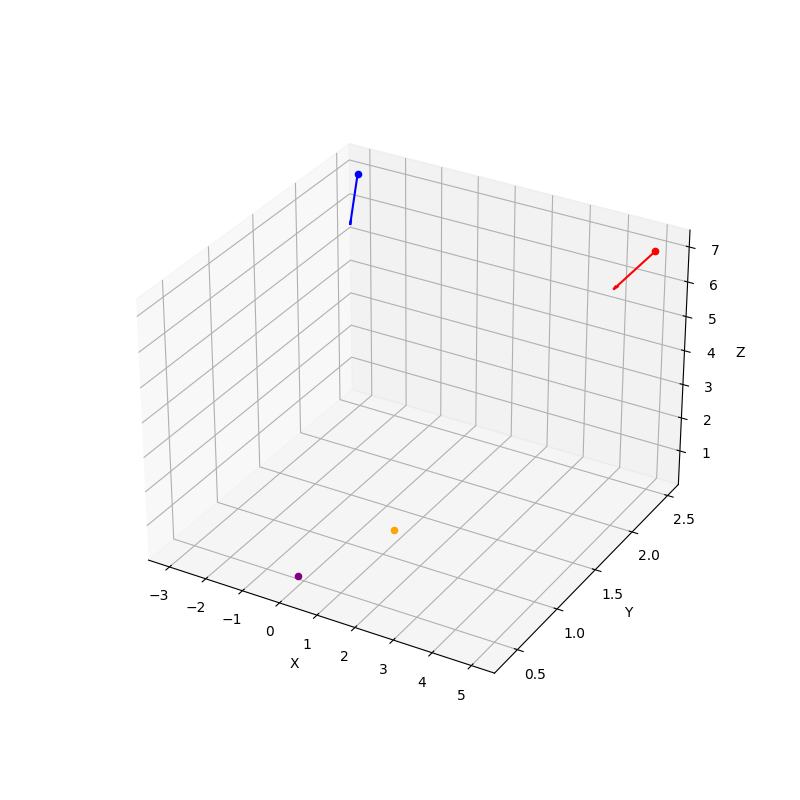

In [4]:
@dataclass
class Camera:
    position: np.ndarray#=field(default_factory=np.array([0., 0., 0.]))
    angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degree
    intrinsic_: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degree
    quaternion: np.ndarray=field(default_factory=np.array([1., 0., 0., 0.]))  # angle in quaternion

    focal_length: float=20.
    resolution: np.ndarray=np.array([3840, 2160])
    sensor_size: np.ndarray=np.array([30, 30])
    fov: float=73.73979

    def __post_init__(self):
        print('info', self.position, self.angle, self.quaternion)
        pitch, yaw, roll = self.angle  # R_x, R_y, R_z

        sin_yaw, cos_yaw = np.sin(np.deg2rad(yaw)), np.cos(np.deg2rad(yaw))
        sin_pitch, cos_pitch = np.sin(np.deg2rad(pitch)), np.cos(np.deg2rad(pitch))
        sin_roll, cos_roll = np.sin(np.deg2rad(roll)), np.cos(np.deg2rad(roll))
        
        self.rotation_yaw = np.array([
            [cos_yaw, 0, -sin_yaw],
            [0, 1, 0],
            [sin_yaw, 0, cos_yaw],       
        ])
        self.rotation_pitch = np.array([
            [1, 0, 0],
            [0, cos_pitch, -sin_pitch],
            [0, sin_pitch, cos_pitch],
        ])
        self.rotation_roll = np.array([
            [cos_roll, -sin_roll, 0],
            [sin_roll, cos_roll, 0],
            [0, 0, 1]
        ])
        # self.rotation = self.rotation_yaw @ self.rotation_pitch @ self.rotation_roll
        self.rotation = self.rotation_roll @ self.rotation_pitch @ self.rotation_yaw

        self.intrinsic = np.array([
            [self.focal_length*self.resolution[0]/self.sensor_size[0], 0, self.resolution[0]/2],
            [0, self.focal_length*self.resolution[1]/self.sensor_size[1], self.resolution[1]/2],
            [0, 0, 1]
        ])
        self.intrinsic_ = np.array(self.intrinsic_).reshape((3, 3))

    def pixel2ray(self, pixel):
        pixel = np.append(pixel, np.zeros((pixel.shape[0], 1)) + 1, axis=-1)
        # camera_coor = pixel @ self.intrinsic_
        camera_coor = pixel @ np.linalg.inv(self.intrinsic)
        camera_coor = camera_coor / camera_coor[:, -1]
        # camera_coor = pixel @ np.linalg.inv(self.intrinsic_)
        world_coor = (camera_coor @ self.rotation)
        vector = world_coor - np.array(self.position)
        directional_vector = vector / np.linalg.norm(vector)

        # print(self.quaternion)
        # q = R.from_quat(self.quaternion)
        # world_coor = q.apply(camera_coor, inverse=True) - self.position
        # directional_vector = world_coor / np.linalg.norm(world_coor)
        
        return [Line(origin=coor, direction=vec) for coor, vec in zip(world_coor, directional_vector)]


@dataclass
class Line:
    origin: np.ndarray
    direction: np.ndarray


def find_points(line_a: Line, line_b: Line):
    n = np.cross(line_a.direction, line_b.direction)
    d = np.abs(np.dot(n, line_a.origin - line_b.origin)) / np.linalg.norm(n)
    
    t_a = np.dot(np.cross(line_b.direction, n), (line_b.origin - line_a.origin)) / np.dot(n, n)
    t_b = np.dot(np.cross(line_a.direction, n), (line_b.origin - line_a.origin)) / np.dot(n, n)

    p_a = line_a.origin + t_a * line_a.direction
    p_b = line_b.origin + t_b * line_b.direction

    return (p_a + p_b) / 2


colors = ['red', 'blue']
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

cameras_ = [
    Camera(position=camera['position'], angle=camera['rotation'], intrinsic_=camera['intrinsic'], quaternion=camera['quaternion'])
    for camera in output['cameras']
]
for i, camera in enumerate(cameras_):
    ax.scatter(*camera.position, color=colors[i])

lines = []
for i, (bbox, camera) in enumerate(zip(output.get('bboxes'), cameras_)):
    pixels = np.array([
        bbox['center']
    ])
    rays = camera.pixel2ray(pixels)
    stack_origin = np.stack([camera.position]*pixels.shape[0])
    ax.quiver(
        stack_origin[:, 0],
        stack_origin[:, 1],
        stack_origin[:, 2],
        np.array([r.direction for r in rays])[:, 0],
        np.array([r.direction for r in rays])[:, 1],
        np.array([r.direction for r in rays])[:, 2],
        color=colors[i], length=1.0, arrow_length_ratio=.1, normalize=True
    )
    lines.append(rays[-1])

point = find_points(*lines)
print('lpm', np.sum((point - output['3D_location'])**2))
print(point)
print(output['3D_location'])
ax.scatter(*point, color='purple')
ax.scatter(*output['3D_location'], color='orange')
plt.show()


In [ ]:
import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        # x, y, z, w = w, x, y, z

        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
        # t21 = np.sqrt(1 + 2 * (w * y - x * z))
        # t22 = np.sqrt(1 - 2 * (w * y - x * z))
        # pitch_y = math.atan2(t21, t22)-np.pi/2
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

quat = [0.540821135, 0.1979939, 0.763159037, -0.293086]

print(
    np.rad2deg(euler_from_quaternion(*quat))
)

In [ ]:
r = R.from_euler('y', 135, degrees=True)
r.as_quat()